In [1]:
#https://matgenb.materialsvirtuallab.org/2017/12/15/Plotting-a-Pourbaix-Diagram.html

# Import necessary tools from pymatgen
from pymatgen import MPRester
from pymatgen.analysis.pourbaix_diagram import PourbaixDiagram, PourbaixPlotter

# Initialize the MP Rester
mpr = MPRester("B7pkHxCQtALPzGRy")



# Pourbaix Entries for newly calculated solids should be added

## Convert ase trajectory files to "Computed Entry"

In [260]:
import sys
import itertools
import json
import re
import warnings
import numpy as np

from monty.json import MontyDecoder, MontyEncoder
from six import string_types
from copy import deepcopy
from tqdm import tqdm

from pymatgen import SETTINGS
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
from pymatgen.core.structure import Structure
from pymatgen.entries.computed_entries import ComputedEntry, ComputedStructureEntry
from pymatgen.entries.exp_entries import ExpEntry
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen import MPRester
from pymatgen.analysis.pourbaix_diagram import PourbaixDiagram, PourbaixPlotter
from pymatgen.analysis.pourbaix_diagram import PourbaixEntry, IonEntry
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.core.ion import Ion
from pymatgen.entries.compatibility import MaterialsProjectAqueousCompatibility

from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.entries.computed_entries import ComputedEntry, ComputedStructureEntry

def traj_to_computed_entry(path):
    """
    Seoin: It converts our own calculations to Computed Entries
    
    Corrections for oxides 
    taken from "https://github.com/materialsproject/pymatgen/blob/7461cfccd32f239291bd50d2b0aebae2cd8088e5/pymatgen/entries/MPCompatibility.yaml"
    """
    correction_dict={}
    correction_dict['O'] = -0.70229  
    correction_dict['Mn'] = -1.68085015096   #Fit to MnO, Mn3O4 and MnO2 (BURP:-1.687)
    correction_dict['Fe'] = -2.733           #Fit to FeO and Fe2O3 (Fe3O4 probably wrong)
    correction_dict['Co'] = -1.874           #Fit to CoO, Co3O4 (BURP:-1.751)
    correction_dict['Cr'] = -2.013           #Fit to Cr2O3 (CrO3 missing) (BURP: -2.067)
    correction_dict['Mo'] = -3.531           #Fit to MoO3 and MoO2 (BURP: -2.668)
    correction_dict['W']=  -4.351           #Fit to WO2 and WO3 (BURP: -2.762)
    correction_dict['V'] =  -1.682           #Fit to V2O3 and V2O5 (VO2 fit is way off) (BURP: -1.764)
    correction_dict['Ni'] = -2.164           #Based on burp version as of Feb 28 2011
        
    """
    Make sure all calculations are performed with 
    MATERIALS PROJECTS calculation settings (especially Pseudopotential, U corrections and xc='PBE')
    """
    
    atoms = read(path+str("final.traj"))
    comp = Composition(str(atoms.symbols))
    energy = read(path+str("final.traj")).get_potential_energy()

    comp_dict={}
    for i in comp:
        comp_dict[str(i)] = int(comp[i])
    
    # Calculate corrections
    element_list = [i for i in comp_dict.keys()]
    correction = 0
    for i in element_list:
        correction += correction_dict[i]*comp_dict[i]
    
    # Add parameters
    parameters={}
    parameters['oxide_type']='oxide'
    
    data={}
    data['oxide_type']='oxide'

    return ComputedEntry(composition=comp, energy=energy, correction=correction, parameters=parameters, data=data, entry_id='sback' , attribute='sback')

## Collect reference states

In [149]:
def get_ion_ref(mpr, chemsys):
    """
      Seoin:  This is to collect reference states. It is taken from "get_pourbaix_entries"
    """
    """
    
    A helper function to get all entries necessary to generate
    a pourbaix diagram from the rest interface.    

    Args:

        chemsys ([str]): A list of elements comprising the chemical system, e.g. ['Li', 'Fe']
    """

    pbx_entries = []
    # Get ion entries first, because certain ions have reference
    # solids that aren't necessarily in the chemsys (Na2SO4)
    url = '/pourbaix_diagram/reference_data/' + '-'.join(chemsys)
    ion_data = mpr._make_request(url)
    ion_ref_comps = [Composition(d['Reference Solid']) for d in ion_data]
    ion_ref_elts = list(itertools.chain.from_iterable(i.elements for i in ion_ref_comps))
    ion_ref_entries = mpr.get_entries_in_chemsys(
            list(set([str(e) for e in ion_ref_elts] + ['O', 'H'])),
            property_data=['e_above_hull'], compatible_only=False)
    compat = MaterialsProjectAqueousCompatibility("Advanced")
    ion_ref_entries = compat.process_entries(ion_ref_entries)
    ion_ref_pd = PhaseDiagram(ion_ref_entries)

    # position the ion energies relative to most stable reference state
    for n, i_d in enumerate(ion_data):
        ion_entry = IonEntry(Ion.from_formula(i_d['Name']), i_d['Energy'])
        refs = [e for e in ion_ref_entries if e.composition.reduced_formula == i_d['Reference Solid']]
        if not refs:
            raise ValueError("Reference solid not contained in entry list")
        stable_ref = sorted(refs, key=lambda x: x.data['e_above_hull'])[0]
        rf = stable_ref.composition.get_reduced_composition_and_factor()[1]
        solid_diff = ion_ref_pd.get_form_energy(stable_ref) \
                                - i_d['Reference solid energy'] * rf
        elt = i_d['Major_Elements'][0]
        correction_factor = ion_entry.ion.composition[elt] \
                                                / stable_ref.composition[elt]
        ion_entry.energy += solid_diff * correction_factor
        pbx_entries.append(PourbaixEntry(ion_entry, 'ion-{}'.format(n)))

    return pbx_entries, ion_ref_entries, ion_ref_pd

## Convert "Computed Entries" to "Pourbaix Entries"

In [171]:
def get_pourbaix_entry_solid(entry,ion_ref_pd):
    """
    This is to calculate formation energies and convert Computed Entries to Pourbaix Entries
    """
    form_e = ion_ref_pd.get_form_energy(entry)
    new_entry = deepcopy(entry)
    new_entry.uncorrected_energy = form_e
    new_entry.correction = 0.0
    pbx_entry = PourbaixEntry(new_entry)
    return pbx_entry

## Test

In [ ]:
elements=['W','Zr']
computed_entry=traj_to_computed_entry('/global/project/projectdirs/m2755/sback/oxide_gaspy/test/W_different_pp/w_pv/')
pbx_entries, ion_ref_entries, ion_ref_pd = get_ion_ref(mpr, elements)
new_pourbaix_entry=get_pourbaix_entry_solid(computed_entry, ion_ref_pd)

## Draw Pourbaix Diagrams using New Solids

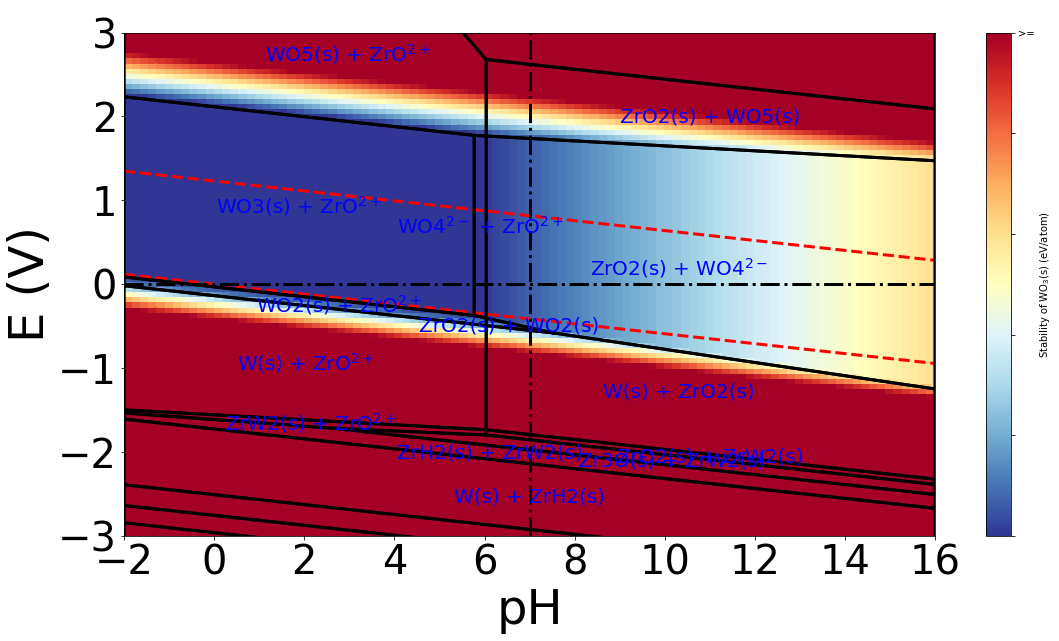

In [269]:
# Get all pourbaix entries corresponding to the chemical system of interest (don't need to include H or O)
pourbaix_entries = mpr.get_pourbaix_entries(elements)

# Add new Pourbaix entries
pourbaix_entries.append(new_pourbaix_entry)


# Construct the PourbaixDiagram object
pbx = PourbaixDiagram(pourbaix_entries)

# Get an entry stability as a function of pH and V
entry = [e for e in pourbaix_entries if e.entry_id == 'sback'][0]

## Below is to plot pourbaix diagram. Don't need this now.
plotter = PourbaixPlotter(pbx)
plt = plotter.plot_entry_stability(entry)
plt.tight_layout()
# plt.savefig(mpid+'.pdf')
# plt.savefig(mpid+'.png')
# plt.savefig(mpid+'.svg')
plt.show()
              

## Draw Pourbaix Diagrams using Materials Projects data

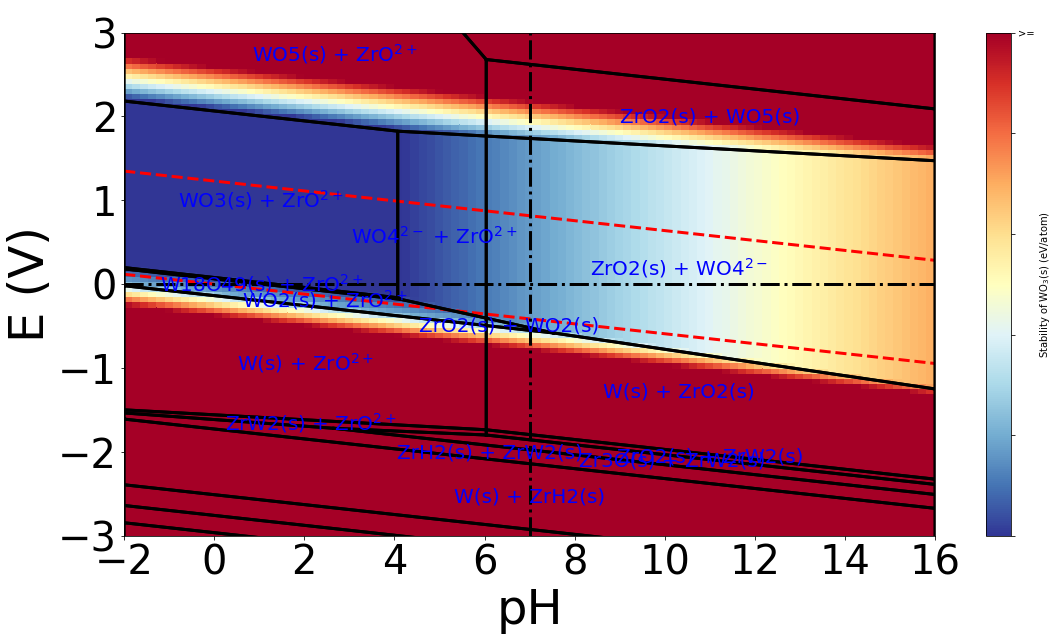

In [268]:
elements=['W','Zr']
mpid='mp-19443'
# Get all pourbaix entries corresponding to the chemical system of interest (don't need to include H or O)
entries = mpr.get_pourbaix_entries(elements)
# Construct the PourbaixDiagram object
pbx = PourbaixDiagram(entries)
# Get an entry stability as a function of pH and V
entry = [e for e in entries if e.entry_id == mpid][0]
## Below is to plot pourbaix diagram. Don't need this now.
plotter = PourbaixPlotter(pbx)
plt = plotter.plot_entry_stability(entry)
plt.tight_layout()
# plt.savefig(mpid+'.pdf')
# plt.savefig(mpid+'.png')
# plt.savefig(mpid+'.svg')
plt.show()
              